## RC Demo experimental design for single run 
### (copy of Olivier's work)

iterate upon the methods for plant RC experiments and focus on techniques for scaling to larger datasets.

- Just a replica of Olivier’s experiment
- Extend to larger datasets of multiple experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

### Loading the dataset

In [2]:
from src.model.rc_dataset import ExperimentDataset 

csv_path = '../datasets/hydroshoot_large.csv'
dataset = ExperimentDataset(csv_path=csv_path)

In [3]:
print(f'Available inputs: \n\t{", ".join(dataset.get_input_variables())}\n'
      f'Available outputs: \n\t{", ".join(dataset.get_output_variables())}\n'
      f'Available state variables: \n\t{", ".join(dataset.get_state_variables())}\n')

Available inputs: 
	input_Tac, input_u, input_hs, input_Rg
Available outputs: 
	output_Rg, output_An, output_E, output_Tleaf
Available state variables: 
	state_Ci, state_gb, state_Ei, state_FluxC, state_Tlc, state_An, state_Flux, state_psi_head, state_u, state_E, state_Eabs, state_gs, state_par_photo.dHd



In [4]:
print(f'Dataset properties:\n'
      f'\tn_runs:     {dataset.n_runs():>3}\n'
      f'\tn_steps:    {dataset.n_steps():>3}\n'
      f'\tstate_size: {dataset.state_size():>3}\n')

Dataset properties:
	n_runs:      84
	n_steps:    168
	state_size: 360



### Selecting a single run to use

Base this on the original HydroShoot experiment: select the run that goes from `2012-08-01 00:00:00` to `2012-08-04 23:00:00`

In [5]:
def find_run(iso_date, dataset):
  for i in range(dataset.n_runs()):
    run_index = dataset.get_target('input_Tac', i).index
    if str(run_index[0]).startswith(iso_date):
      return i
  return -1 

run_id = find_run('2012-08-01', dataset)
print(f'We will use run {run_id} for this notebook.')

We will use run 58 for this notebook.


### Selecting a subset of state observations

For now, we continue with the strategy of taking many random samples of N state positions and calculating the mean and variance on model performance.

In [6]:
def get_state_random_subset(state: pd.DataFrame, state_size: int) -> pd.DataFrame:
  choice = np.random.choice(state.shape[1], size=state_size, replace=False)
  return state.iloc[:, choice]

In [7]:
STATE_VARIABLE = 'state_An'
STATE_SIZE = 16
N_SAMPLES = 16

np.random.seed(42)

state = dataset.get_state(STATE_VARIABLE, run_id).sort_index()
state_sample = get_state_random_subset(state, STATE_SIZE)
print(f'State shape: {state_sample.shape}')

State shape: (168, 16)


In [8]:
TARGET = 'input_Rg'

target = dataset.get_target(TARGET, run_id)
target.shape

(168,)

### Pre-processing data

Let's take a look at the reservoir data first.

In [95]:
"""Normalizing values"""


def scalar_normal_scale_df(df: pd.DataFrame) -> pd.DataFrame:
  array = df.to_numpy()
  mean = array.mean()
  std = array.std()
  array = (array - mean) / std
  return pd.DataFrame(array, columns=df.columns, index=df.index)
  
def scalar_normal_scale_series(series: pd.Series) -> pd.Series:
  array = series.to_numpy()
  mean = array.mean()
  std = array.std()
  array = (array - mean) / std
  return pd.Series(array, index=series.index)

target_sample = scalar_normal_scale_series(target)
state_sample = scalar_normal_scale_df(state_sample)

In [10]:
"""Removing nighttime data"""
from src.learning.preprocessing import generate_mask

daylight_mask = generate_mask(5, 21)
day_length = daylight_mask.sum()
daylight_mask_run = np.tile(daylight_mask, target_sample.shape[0] // 24)

target_sample = target_sample.iloc[daylight_mask_run]
state_sample = state_sample.iloc[daylight_mask_run, :]

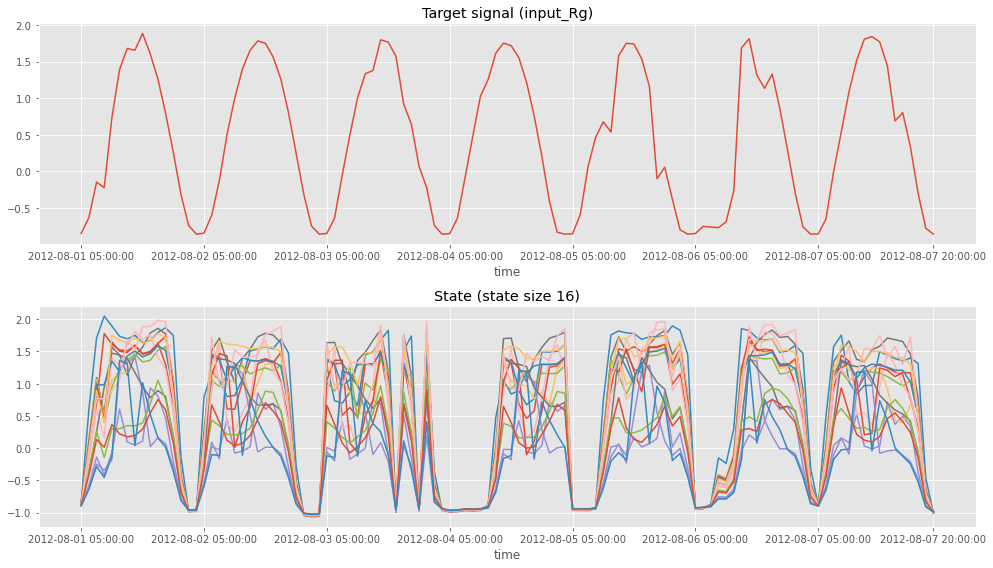

In [11]:
with plt.style.context('ggplot'):
  fig, ax = plt.subplots(2, 1, figsize=(14,8), squeeze=False, tight_layout=True)
  target_sample.plot(ax=ax[0, 0], legend=False, title=f'Target signal ({TARGET})')
  ax[0,0].set_xticks([*list(range(0, target_sample.shape[0], day_length)), target_sample.shape[0] - 1])
  ax[0,0].set_xticklabels([*target_sample.index[::day_length], target_sample.index[-1]])
  state_sample.plot(ax=ax[1, 0], legend=False, title=f'State (state size {state_sample.shape[1]})')
  ax[1,0].set_xticks([*list(range(0, state_sample.shape[0], day_length)), state_sample.shape[0] - 1])
  ax[1,0].set_xticklabels([*state_sample.index[::day_length], state_sample.index[-1]])
  plt.show()

### Fitting

#### Train-test split

Train-test splitting from Pieters et al:

- Use alternating days as training and testing dataset (4 days train, 3 days test)
- Use all days (no discarding of warmup for now)

In [86]:
"""Split data in a training and testing set."""

arr_state = state_sample.to_numpy()
arr_target = target_sample.to_numpy()

def split_train_test(array: np.ndarray, day_length: int) -> np.ndarray:
  """Splits the data in a train and test set by alternating days.
  (samples, state_vars) -> (day, day_samples, state_vars)"""
  n_samples = array.shape[0]
  dimensions = array.shape[1:]
  array_days = array.reshape((n_samples // day_length, -1, *array.shape[1:]))
  return array_days[::2], array_days[1::2]




X_train, X_test = split_train_test(arr_state, day_length)
y_train, y_test = split_train_test(arr_target, day_length)

print(f'Training data:\n' +
      f'\tX: {X_train.shape}\n'
      f'\ty: {y_train.shape}\n'
      f'Test data:\n'
      f'\tX: {X_test.shape}\n'
      f'\ty: {y_test.shape}\n'
      )

  

Training data:
	X: (4, 16, 16)
	y: (4, 16)
Test data:
	X: (3, 16, 16)
	y: (3, 16)



#### Grouping

Grouping stategy from Pieters et al:

- Cross-validate using leave-one-out on the days (3 days for training, 1 for validation)

In [87]:
from sklearn.model_selection import LeaveOneGroupOut

folds = LeaveOneGroupOut()

In [88]:
# Every sample should be its own group
groups = np.arange(X_train.shape[0]).repeat(day_length).reshape(y_train.shape)

print('Groups shape:', groups.shape)
print('Group ids:', np.unique(groups))

Groups shape: (4, 16)
Group ids: [0 1 2 3]


In [101]:
def arr_func(*args):
  return list(map(lambda x: x**2, args))


In [89]:
def flatten_data(array: np.ndarray) -> np.ndarray:
  """Flattens dataset that is grouped per day in the first dimension:
  (n_days, day_length, *dims) -> (n_days * day_length, *dims)"""
  dimensions = array.shape[2:]
  return array.reshape((-1, *dimensions))


X_train = flatten_data(X_train)
y_train = flatten_data(y_train)
X_test = flatten_data(X_test)
y_test = flatten_data(y_test)
groups = flatten_data(groups)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('groups:', groups.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (64, 16)
y_train: (64,)
groups: (64,)

X_test: (48, 16)
y_test: (48,)


#### Defining the model pipeline

In [90]:
 """Define readout model pipeline and hyperparameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Define model
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

# define search grid
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 100)
}]

#### Fitting the model for one target

In [91]:
from src.learning.training import get_cv_score, perform_gridsearch

cv_scores = get_cv_score(readout, X_train, y_train, groups, folds, verbose=True)
tuned_readout, tuned_cv_scores = perform_gridsearch(readout, X_train, y_train, groups, folds, search_grid, verbose=True)

Cross-validation scores:
  - Train: -0.4335 +/- 0.11524
  - CV:    -0.9314 +/- 0.45288
Cross-validation scores after tuning:
  - Train: -0.5833 +/- 0.12480
  - CV:    -0.7177 +/- 0.33023
Optimal hyperparameters:
  - ridge_regression__alpha = 45.34878508128582


Test scores

In [94]:
from src.learning.scorers import nmse_scorer

score = nmse_scorer(tuned_readout, X_test, y_test)
print(f'test score: {score:.3f}')

test score: -0.688


### Write method for performing N randomly sampled fits

In [108]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.base import BaseEstimator
from src.learning.preprocessing import generate_mask
from src.learning.scorers import nmse_scorer


def scalar_normal_scale_df(df: pd.DataFrame) -> pd.DataFrame:
  array = df.to_numpy()
  mean = array.mean()
  std = array.std()
  array = (array - mean) / std
  return pd.DataFrame(array, columns=df.columns, index=df.index)
  

def scalar_normal_scale_series(series: pd.Series) -> pd.Series:
  array = series.to_numpy()
  mean = array.mean()
  std = array.std()
  array = (array - mean) / std
  return pd.Series(array, index=series.index)


def split_train_test(array: np.ndarray, day_length: int) -> np.ndarray:
  """Splits the data in a train and test set by alternating days.
  (samples, state_vars) -> (day, day_samples, state_vars)"""
  n_samples = array.shape[0]
  dimensions = array.shape[1:]
  array_days = array.reshape((n_samples // day_length, -1, *array.shape[1:]))
  return array_days[::2], array_days[1::2]


def flatten_data(*array: np.ndarray) -> np.ndarray:
  """Flattens dataset that is grouped per day in the first dimension:
  (n_days, day_length, *dims) -> (n_days * day_length, *dims)"""
  
  def _flatten_data(array):
    dimensions = array.shape[2:]
    return array.reshape((-1, *dimensions))

  return list(map(_flatten_data, array))


def get_state_random_subset(state: pd.DataFrame, state_size: int) -> pd.DataFrame:
  choice = np.random.choice(state.shape[1], size=state_size, replace=False)
  return state.iloc[:, choice]


def perform_N_fits(n_samples: int, dataset: ExperimentDataset, estimator: BaseEstimator, 
                  search_grid: dict, run_id: int, target: str, state_var: str, state_size: int):
  """Randomly samples the state space n_samples times (may overlap between samples).
  Fits a model with Pieters et al. train-test split and grouping strategy, + discarding nighttime data.

  Returns array of test scores.
  """
  state = dataset.get_state(state_var, run_id).sort_index()
  target = target = dataset.get_target(target, run_id)

  # Normalize target and state data to zero mean and unit variance.
  state = scalar_normal_scale_df(state)
  target = scalar_normal_scale_series(target)

  # Apply daylight mask to discard night time samples.
  daylight_mask = generate_mask(5, 21)
  day_length = daylight_mask.sum()
  daylight_mask_run = np.tile(daylight_mask, target_sample.shape[0] // 24)
  state = state.iloc[daylight_mask_run, :]
  target = target.iloc[daylight_mask_run]

  # Reshape target data and generate groups
  y_train, y_test = split_train_test(target.to_numpy(), day_length)  

  # Assign CV grouping strategy
  folds = LeaveOneGroupOut()
  groups = np.arange(len(y_train)).repeat(day_length).reshape(y_train.shape)

  # Flatten group and target data
  y_train, y_test, groups = flatten_data(y_train, y_test, groups)
  
  test_scores = np.zeros((n_samples))

  for i_sample in tqdm(range(n_samples)):
    state_sample = get_state_random_subset(state, state_size)
    X_train, X_test = split_train_test(state_sample.to_numpy(), day_length)
    X_train, X_test = flatten_data(X_train, X_test)
    tuned_readout, tuned_cv_scores = perform_gridsearch(readout, X_train, y_train, groups, folds, search_grid, verbose=False)
    score = nmse_scorer(tuned_readout, X_test, y_test)
    test_scores[i_sample] = score

  return test_scores

np.random.seed(42)
perform_N_fits(16, dataset, readout, search_grid, run_id, TARGET, STATE_VARIABLE, STATE_SIZE)

100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


array([-0.68867707, -0.70015082, -0.7019055 , -0.70536911, -0.72326388,
       -0.69701918, -0.71664123, -0.70199206, -0.69740862, -0.69567769,
       -0.69112709, -0.70859172, -0.69064076, -0.69678899, -0.70139534,
       -0.7132226 ])